In [6]:
%matplotlib inline

In [1]:
import dwave_networkx as dnx
import networkx as nx
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler
from hybrid.decomposers import _chimeralike_to_zephyr
import numpy as np

import torch

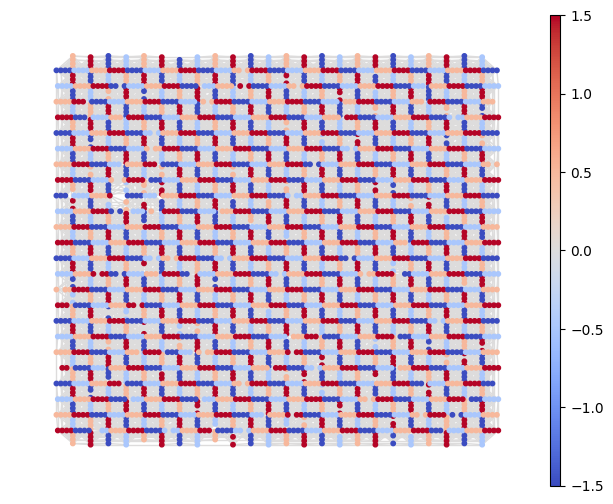

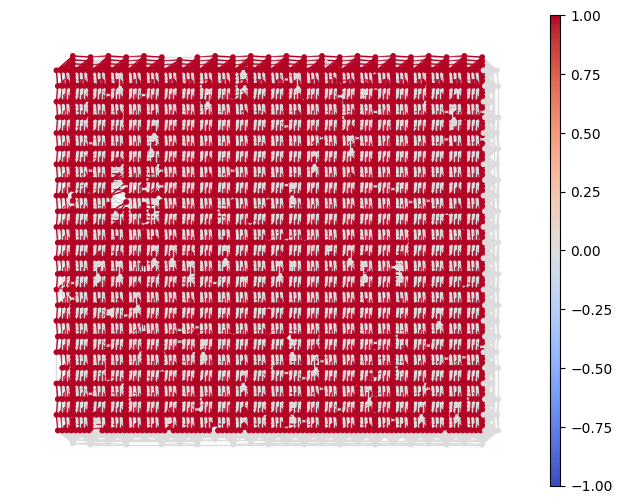

total qubits 4800
max degree 20


In [10]:
#grid parameter: m
#tile parameter: t
online = True
# https://www.dwavequantum.com/media/fawfas04/14-1056a-a_zephyr_topology_of_d-wave_quantum_processors.pdf 
if online:
    qpu = DWaveSampler(solver={'topology__type': 'zephyr'})  # Or specify name
    # qpu = DWaveSampler(solver={'topology__type': 'pegasus'})  # Or specify name
    m, t = qpu.properties['topology']['shape']
    graph = dnx.zephyr_graph(m=m, t=t,
                             node_list=qpu.nodelist, edge_list=qpu.edgelist)
    coordinated_graph = nx.relabel_nodes(
        graph,
        {q: dnx.zephyr_coordinates(m,t).linear_to_zephyr(q)
         for q in graph.nodes})
    # NB, you can relabel back to linear coordinates with zephyr_to_linear.
    node_size = 10
else:
    # Smaller defect free case for visualization, can be executed locally
    m = 2
    t = 4
    # verticals and horizontals are clustered into groups of (t=4), you can
    # get a better understanding by playing with smaller t values
    coordinated_graph = dnx.zephyr_graph(m=m, t=t, coordinates=True)
    node_size = 15
# u, w, k, j, z ; see paper.
coloring = {q : (2*q[0]+q[1] + 2*q[4]+q[3])%4 for q in coordinated_graph.nodes}
assert all(coloring[q1] != coloring[q2] for q1,q2 in coordinated_graph.edges)
color_n = {q : (coloring[q]-1.5) for q in coordinated_graph.nodes} # for contrast, this coloring scheme takes a linear index.
color_e = {e : 0 for e in coordinated_graph.edges}
plt.figure(1)
dnx.draw_zephyr(coordinated_graph,linear_biases=color_n, quadratic_biases=color_e, node_size=node_size)
# plt.savefig('/home/javier/Projects/CaloQVAE/figs/DWAVE/figure_zephyr_small.png')

# There are many 'Chimera graphs' as subgraphs of zephyr, here is one example
# that is supported in the code base (I like it because it plays nice with
# default visualizations -- highly symmetric
m_chimera = n_chimera = 2*m
t_chimera = t
graph = dnx.chimera_graph(m_chimera, n_chimera, t_chimera, coordinates=True)
nodes_map = {n: _chimeralike_to_zephyr(n) for n in graph.nodes}
nodes = set(nodes_map.values())
edges = {(nodes_map[n1], nodes_map[n2]) for n1,n2 in graph.edges}
edges = edges | {(n2,n1) for n1,n2 in edges}
# Draw as chimera subgraph:
color_n = {n: int(n in nodes) for n in coordinated_graph.nodes}
color_e = {e: int(e in edges) for e in coordinated_graph.edges}
plt.figure(2)
dnx.draw_zephyr(coordinated_graph, linear_biases=color_n,
                quadratic_biases=color_e,
                node_size=node_size)
# plt.savefig('/home/javier/Projects/CaloQVAE/figs/DWAVE/figure_zephyr_small_chim_embedded.png')
plt.show()
print("total qubits", 8*t*m*m + 4*t*m)
print("max degree", 4*(t+1))